### Image Classification using CNN

Topic - Cats or Dogs
Method - Alexnet and VGG16

<h3>Dataset link :  https://www.microsoft.com/en-us/download/details.aspx?id=54765

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pre-Processing

In [ ]:
import os
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt


path='./drive/MyDrive/data'
print(os.listdir(path+'/train'))
print('\nTotal Number of Categories: ',len(os.listdir(path+'/train')))

['Cat', 'Dog']

Total Number of Categories:  2


In [ ]:
for i in os.listdir(path):
  print('Number of images in ',i)
  for j in os.listdir(path+'/'+i):
    print(j,':',len(os.listdir(path+'/'+i+'/'+j)))
  print('\n')

Number of images in  train
Cat : 1000
Dog : 1000


Number of images in  valid
Cat : 500
Dog : 500


Number of images in  test
Cat : 500
Dog : 500




In [ ]:
#Define Directories for train, test & Validation Set
train_path = path+'/train'
test_path = path+'/test'
valid_path = path+'/valid'
batch_size = 16
img_height = 225
img_width = 225


 # Preparing the Data

Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )
test_data_gen = ImageDataGenerator(rescale = 1./255)

Loading the Images

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      shuffle=False,
      class_mode='binary',
      batch_size=1
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      class_mode='binary',
      batch_size=batch_size
      )

Found 1998 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Visualizing  the data

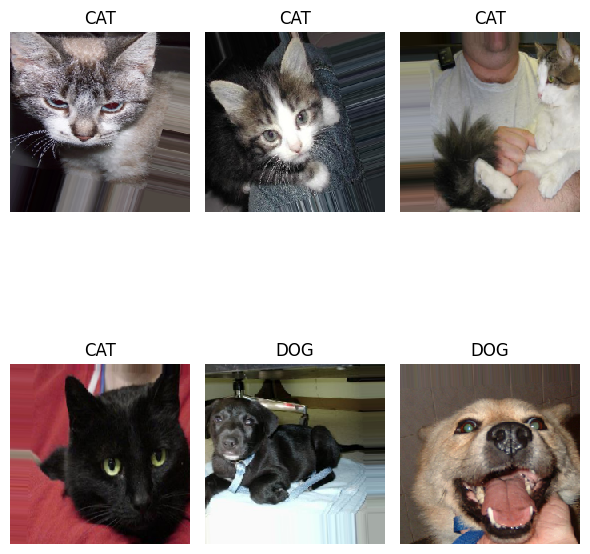

In [ ]:
plt.figure(figsize=(6, 8))
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'CAT', 1:'DOG'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),interpolation='nearest')
        break
plt.tight_layout()
plt.show()

#Alexnet model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
#AlexNet model
def create_model():
  model = Sequential()

  # First Convolutional Layer
  model.add(Conv2D(96,(11, 11), strides=(4, 4), activation='relu', input_shape=(img_width, img_height, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((3, 3), strides=(2, 2)))

  # Second Convolutional Layer
  model.add(Conv2D(256,(5, 5), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((3, 3), strides=(2, 2)))

  # Third Convolutional Layer
  model.add(Conv2D(384,(3, 3), activation='relu'))
  model.add(BatchNormalization())

  # Fourth Convolutional Layer
  model.add(Conv2D(384,(3, 3), activation='relu'))
  model.add(BatchNormalization())

  # Fifth Convolutional Layer
  model.add(Conv2D(256,(3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((3, 3), strides=(2, 2)))

  # Flatten the input for fully connected layers
  model.add(Flatten())

  # First Fully Connected Layer
  model.add(Dense(units=4096, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Second Fully Connected Layer
  model.add(Dense(4096, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Output Layer for binary classification
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

<h3>For output shape,

output_height = (input_height - filter_height + 2 * padding) / stride + 1

output_width = (input_width - filter_width + 2 * padding) / stride + 1

<h3>For max pooling layer,

output_height = (input_height - pool_height) / stride + 1

output_width = (input_width - pool_width) / stride + 1

<h3>For parameters,

params = (filter_height * filter_width * input_channels + 1) * output_channels



In [ ]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [learning_rate_reduction]

#fit the model

In [ ]:
model.fit(train,epochs=40, validation_data=valid, callbacks=callbacks_list)

Epoch 1/40
125/125 [==============================] - 135s 943ms/step - loss: 1.6786 - accuracy: 0.4975 - val_loss: 1.1206 - val_accuracy: 0.5210 - lr: 0.0010
Epoch 2/40
125/125 [==============================] - 38s 306ms/step - loss: 0.9840 - accuracy: 0.5020 - val_loss: 0.9431 - val_accuracy: 0.5270 - lr: 0.0010
Epoch 3/40
125/125 [==============================] - 37s 294ms/step - loss: 0.9240 - accuracy: 0.5280 - val_loss: 0.8479 - val_accuracy: 0.5450 - lr: 0.0010
Epoch 4/40
125/125 [==============================] - 37s 295ms/step - loss: 0.8922 - accuracy: 0.5335 - val_loss: 1.0666 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 5/40
125/125 [==============================] - ETA: 0s - loss: 0.9301 - accuracy: 0.5205
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
125/125 [==============================] - 37s 295ms/step - loss: 0.9301 - accuracy: 0.5205 - val_loss: 0.9407 - val_accuracy: 0.5040 - lr: 0.0010
Epoch 6/40
125/125 [============================

#Evaluate the model and visualize it

<Axes: >

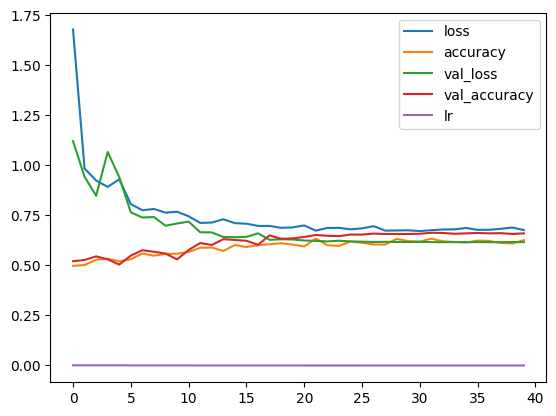

In [ ]:
pd.DataFrame(model.history.history).plot()

X axis: number of epochs

Y axis: evaluation metrics

In [ ]:
model.save_weights('cat_dog_classifier_W.h5')

Testing

In [ ]:
model=create_model()
model.load_weights('cat_dog_classifier_W.h5')

In [ ]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

 954/1000 [===========================>..] - ETA: 0s - loss: 0.6296 - accuracy: 0.6520

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1000/1000 [==============================] - 8s 8ms/step - loss: 0.6282 - accuracy: 0.6560
The testing accuracy is : 65.6000018119812 %


In [ ]:
test_data= test_data_gen.flow_from_directory(
  test_path,
  target_size=(img_height, img_width),
  shuffle=False,
  batch_size=1,
)

Found 1000 images belonging to 2 classes.


In [ ]:
preds=[]
targets=[]
c=0
for x,y in test_data:
  if c>1000:
    break
  p=model.predict(x,verbose=None)
  p=0 if p.item()<0.5 else 1
  y=np.argmax(y,axis=1)
  preds.append(p)
  targets=np.concatenate((targets,y))
  c+=1


<Axes: >

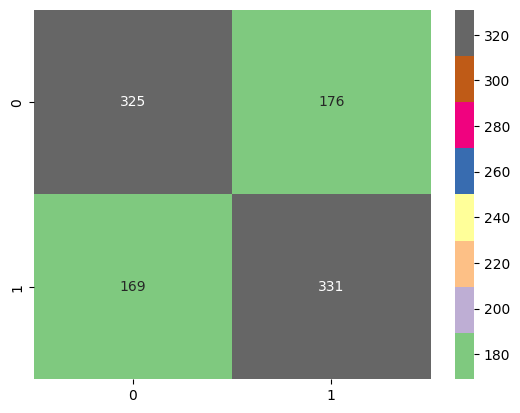

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns
sns.heatmap(confusion_matrix(targets,preds),annot=True,fmt=".0f",cmap='Accent')

# Classification Report

In [ ]:
print(classification_report(targets,preds))

              precision    recall  f1-score   support

         0.0       0.66      0.65      0.65       501
         1.0       0.65      0.66      0.66       500

    accuracy                           0.66      1001
   macro avg       0.66      0.66      0.66      1001
weighted avg       0.66      0.66      0.66      1001



In [ ]:
accuracy_score(targets,preds)

0.6553446553446554

An accuracy of around 65% for an image classification task using the AlexNet architecture could be indicative of several potential challenges. AlexNet, being an earlier convolutional neural network (CNN) model, might struggle to capture intricate and complex patterns present in the dataset. This could be attributed to its relatively simpler architecture compared to more advanced models developed later.

# VGG16 MODEL

In [ ]:
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model

In [ ]:
def vgg16():
  base_model = VGG16(weights='imagenet', include_top=False,input_shape=(img_width, img_height, 3))

  base_model.trainable = False

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)
  predictions = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

<h3>For calculations,

 parameter = (filter_height * filter_width * input_channels + 1) * output_channels

<h3>For outshape calculations,

output_height = (input_height - filter_height + 2 * padding) / stride + 1


output_width = (input_width - filter_width + 2 * padding) / stride + 1



In [ ]:
vgg=vgg16()

vgg.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 225, 225, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 225, 225, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 225, 225, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
vgg.fit(train,epochs=20, validation_data=valid, callbacks=callbacks_list)

Epoch 1/20
125/125 [==============================] - 49s 364ms/step - loss: 0.5973 - accuracy: 0.6787 - val_loss: 0.4076 - val_accuracy: 0.8430 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - 45s 361ms/step - loss: 0.4469 - accuracy: 0.8018 - val_loss: 0.3253 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - 42s 336ms/step - loss: 0.3619 - accuracy: 0.8473 - val_loss: 0.2808 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - 41s 332ms/step - loss: 0.3509 - accuracy: 0.8544 - val_loss: 0.2795 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 5/20
125/125 [==============================] - 42s 332ms/step - loss: 0.3166 - accuracy: 0.8614 - val_loss: 0.2245 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 6/20
125/125 [==============================] - 41s 326ms/step - loss: 0.3134 - accuracy: 0.8644 - val_loss: 0.2046 - val_accuracy: 0.9170 - lr: 0.0010
Epoch 7/20
125/125 [==============================] 

<Axes: >

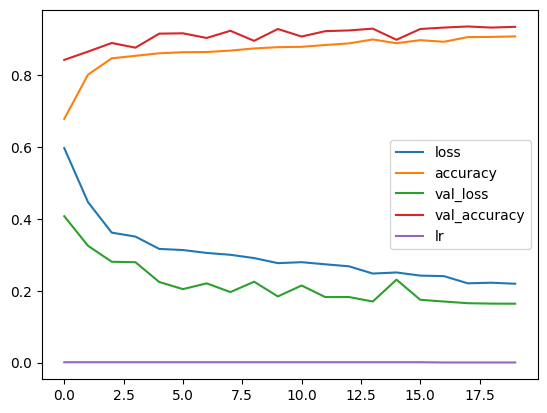

In [ ]:
pd.DataFrame(vgg.history.history).plot()

X axis: number of epochs

Y axis: evaluation metrics

In [ ]:
vgg.save_weights('image_classifier_vgg.h5')

VGG16 testing

In [ ]:
vgg=vgg16()
vgg.load_weights('image_classifier_vgg.h5')

In [ ]:
test_accu = vgg.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

1000/1000 [==============================] - 11s 11ms/step - loss: 0.1687 - accuracy: 0.9310
The testing accuracy is : 93.09999942779541 %


In [ ]:
preds=[]
targets=[]
c=0
for x,y in test_data:
  if c>1000:
    break
  p=vgg.predict(x,verbose=None)
  p=0 if p.item()<0.5 else 1
  y=np.argmax(y,axis=1)
  preds.append(p)
  targets=np.concatenate((targets,y))
  c+=1


<Axes: >

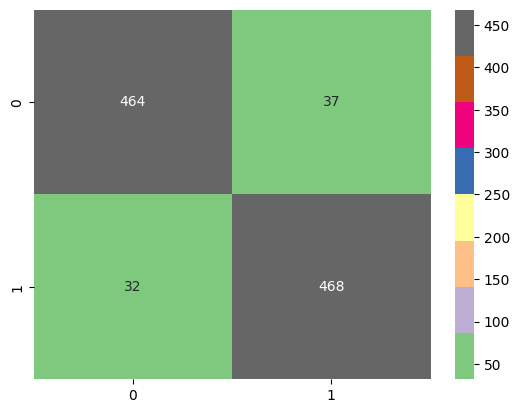

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns
sns.heatmap(confusion_matrix(targets,preds),annot=True,fmt=".0f",cmap='Accent')

#CLASSIFICATION REPORT FOR VGG16

In [ ]:
print(classification_report(targets,preds))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       501
         1.0       0.93      0.94      0.93       500

    accuracy                           0.93      1001
   macro avg       0.93      0.93      0.93      1001
weighted avg       0.93      0.93      0.93      1001



In [ ]:
accuracy_score(targets,preds)


0.9310689310689311

Comparison

 The VGG16 model's superiority in accuracy over AlexNet stems from its architectural depth, complexity, efficient regularization, and its ability to learn intricate patterns through an ensemble of diverse filters. The model's hierarchical learning capabilities and the advantages of transfer learning further solidify its effectiveness in capturing nuanced features, resulting in enhanced accuracy for image classification tasks.

Conclusion

I have used VGG and alexnet.
For both the models I hav worked on the fully connected layer,by which i got an improvised accuracy of 93% for VGG16 and If we look at the Alexnet model, I got an accuracy of 65%.
Fine-tuning a pre-trained model like VGG16 on the specific dataset allows it to build upon already learned features. This often leads to quicker convergence and improved accuracy.